In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gpplot as gpp
from scipy.stats import normaltest
gpp.set_aesthetics(context = 'paper')



Supplementary Data 4 of [DeWeirdt 2022 Nat Commun](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9448816/#MOESM8). Designed PAM-tiling library of 201 essential and 198 nonessential genes to validate RS3 model, which predicts on-target activity from sgRNA features. Read counts obtained from CRISPR/Cas9 (Chen tracr) viability screen in A375 cells.

The goal of this notebook is to identify nonessential-targeting guides, and, of those, identify which are depleted. Since nonessential-targeting guides are not expected to deplete, this guides are understood to be having substantial off-target activity ("promiscuous guides"). The output of this notebook is the list of nonessential-targeting guides annotated as either promiscuous or non-promiscuous for the sake of developing a classifier for guide promiscuity.

### Data Cleaning

In [2]:
#importing plate 1 and 2 and merging them
reads_df = pd.read_excel("../Data/deweirdt_2022_suppdata4.xlsx",sheet_name="Chen_2013_tracr_read_counts",skiprows=[0,1])
reads_df

,sgRNA Sequence,pDNA,RepA,RepB,RepC
0,AAAAAAAAGCACTGTCATGC,161,2651,2707,3805
1,AAAAAAAGCACTGTCATGCA,183,1879,1362,3594
2,AAAAAAAGGGAGGACCACTG,160,684,177,1196
3,AAAAAAAGGGCTGCCCCAAA,259,816,512,2605
4,AAAAAAAGTAGTGTGAAGTC,177,391,276,1637
...,...,...,...,...,...
84604,TTTGTTGTATGATAAACATC,120,523,111,238
84605,TTTGTTTCAGACTTTGTTTC,242,2401,2236,3680
84606,TTTGTTTCTCAGGACCGCAT,217,0,73,207
84607,TTTGTTTCTCTTTCTACAAG,290,2716,1986,4269


In [3]:
def lognorm(reads):
    """
    Standardize read counts by calculating reads per million,
    adding a pseudo-count of one, and taking the log2

    :param reads: numpy or pandas array
    :returns: numpy or pandas array
    """
    reads_per_million = (reads/reads.sum())*(10**6)
    lognormed_reads = np.log2(reads_per_million + 1)
    return lognormed_reads
condition_columns = ['pDNA', 'RepA', 'RepB',
                     'RepC']
lognorm_df = reads_df.copy()
lognorm_df[condition_columns] = lognorm_df[condition_columns].apply(lognorm)
condition_columns.remove("pDNA")
lognorm_df

,sgRNA Sequence,pDNA,RepA,RepB,RepC
0,AAAAAAAAGCACTGTCATGC,3.409039,5.106229,5.146635,4.628563
1,AAAAAAAGCACTGTCATGCA,3.577402,4.626764,4.195335,4.549677
2,AAAAAAAGGGAGGACCACTG,3.400899,3.267442,1.700802,3.080811
3,AAAAAAAGGGCTGCCCCAAA,4.042603,3.497573,2.908974,4.108569
4,AAAAAAAGTAGTGTGAAGTC,3.533398,2.568731,2.173047,3.486965
...,...,...,...,...,...
84604,TTTGTTGTATGATAAACATC,3.030686,2.925656,1.269948,1.313068
84605,TTTGTTTCAGACTTTGTTTC,3.950795,4.967682,4.879414,4.582352
84606,TTTGTTTCTCAGGACCGCAT,3.804192,0.000000,0.947332,1.196172
84607,TTTGTTTCTCTTTCTACAAG,4.196315,5.140173,4.714516,4.788212


In [4]:
#remove underrepresented sgRNAs
filtered_lognorms = lognorm_df.copy()
z_low = -3  # minimum z-score
# Z-score the pDNA column
filtered_lognorms["pDNA_zscore"] = (filtered_lognorms['pDNA'] - filtered_lognorms['pDNA'].mean())/filtered_lognorms['pDNA'].std()
# Filter by z-score
filtered_lognorms = filtered_lognorms[filtered_lognorms["pDNA_zscore"] > z_low].reset_index(drop=True)
# Drop z-scored columns
filtered_lognorms = filtered_lognorms.drop("pDNA_zscore", axis=1)
filtered_lognorms

,sgRNA Sequence,pDNA,RepA,RepB,RepC
0,AAAAAAAAGCACTGTCATGC,3.409039,5.106229,5.146635,4.628563
1,AAAAAAAGCACTGTCATGCA,3.577402,4.626764,4.195335,4.549677
2,AAAAAAAGGGAGGACCACTG,3.400899,3.267442,1.700802,3.080811
3,AAAAAAAGGGCTGCCCCAAA,4.042603,3.497573,2.908974,4.108569
4,AAAAAAAGTAGTGTGAAGTC,3.533398,2.568731,2.173047,3.486965
...,...,...,...,...,...
84340,TTTGTTGTATGATAAACATC,3.030686,2.925656,1.269948,1.313068
84341,TTTGTTTCAGACTTTGTTTC,3.950795,4.967682,4.879414,4.582352
84342,TTTGTTTCTCAGGACCGCAT,3.804192,0.000000,0.947332,1.196172
84343,TTTGTTTCTCTTTCTACAAG,4.196315,5.140173,4.714516,4.788212


Calculating the log fold change of every guide: abundance at late time point relative to early time point (pDNA)

In [5]:
lfc_df = filtered_lognorms.copy()
for col in condition_columns:
    lfc_df[col] = filtered_lognorms[col] - filtered_lognorms["pDNA"]
lfc_df=lfc_df.drop("pDNA",axis=1)
lfc_df

,sgRNA Sequence,RepA,RepB,RepC
0,AAAAAAAAGCACTGTCATGC,1.697189,1.737596,1.219524
1,AAAAAAAGCACTGTCATGCA,1.049362,0.617933,0.972275
2,AAAAAAAGGGAGGACCACTG,-0.133457,-1.700097,-0.320088
3,AAAAAAAGGGCTGCCCCAAA,-0.545030,-1.133630,0.065966
4,AAAAAAAGTAGTGTGAAGTC,-0.964667,-1.360352,-0.046433
...,...,...,...,...
84340,TTTGTTGTATGATAAACATC,-0.105030,-1.760738,-1.717618
84341,TTTGTTTCAGACTTTGTTTC,1.016887,0.928619,0.631557
84342,TTTGTTTCTCAGGACCGCAT,-3.804192,-2.856860,-2.608019
84343,TTTGTTTCTCTTTCTACAAG,0.943857,0.518201,0.591896


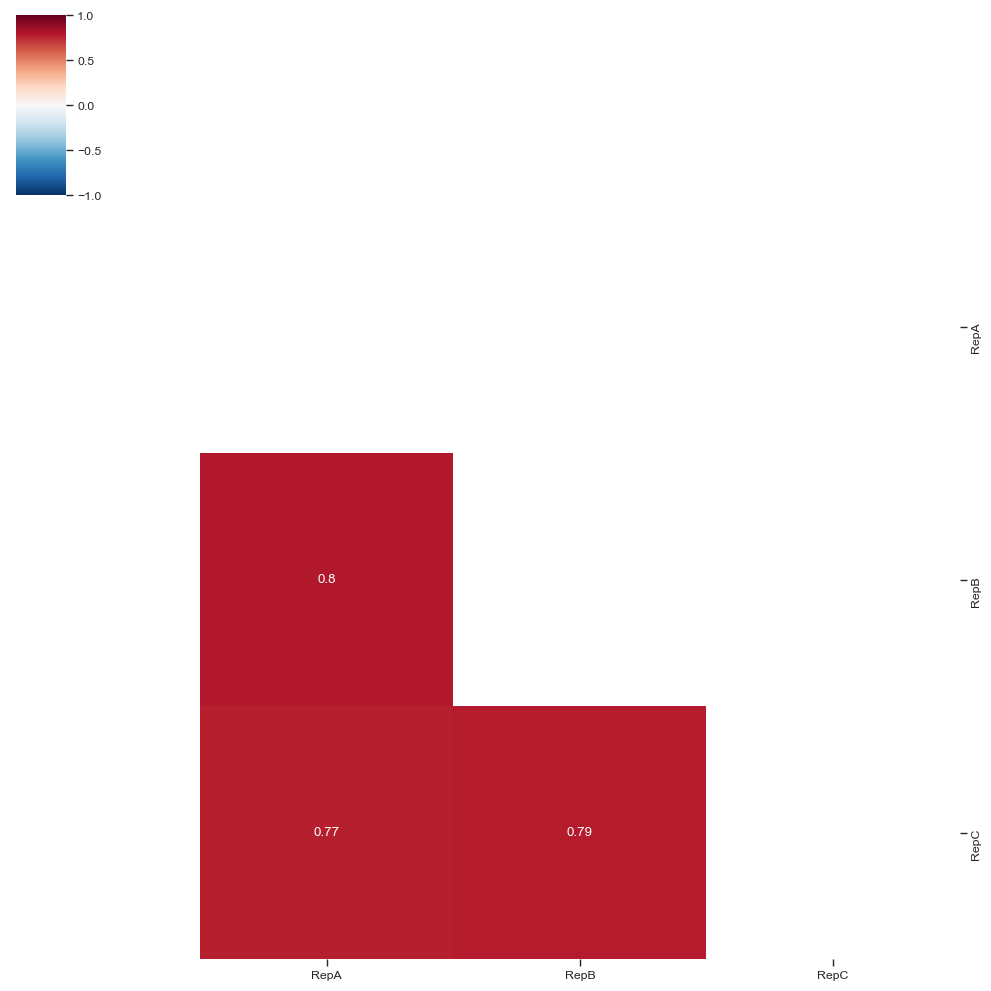

In [6]:
#check replicate correlation
lfc_correlations = lfc_df.corr(numeric_only=True)
matrix=np.triu(lfc_correlations)
sns.clustermap(lfc_correlations, cmap='RdBu_r',
               vmin=-1, vmax=1, annot=True,row_cluster=False,col_cluster=False,mask=matrix)


In [7]:
#adequate replicate correlation: take average
lfc_df["sgRNA_lfc"]=lfc_df.mean(axis=1,numeric_only=True)
lfc_df=lfc_df.drop(condition_columns,axis=1)
lfc_df

,sgRNA Sequence,sgRNA_lfc
0,AAAAAAAAGCACTGTCATGC,1.551436
1,AAAAAAAGCACTGTCATGCA,0.879857
2,AAAAAAAGGGAGGACCACTG,-0.717881
3,AAAAAAAGGGCTGCCCCAAA,-0.537565
4,AAAAAAAGTAGTGTGAAGTC,-0.790484
...,...,...
84340,TTTGTTGTATGATAAACATC,-1.194462
84341,TTTGTTTCAGACTTTGTTTC,0.859021
84342,TTTGTTTCTCAGGACCGCAT,-3.089690
84343,TTTGTTTCTCTTTCTACAAG,0.684651


Retrieving guide mappings from the GPP LIMS tool to ensure the most up-to-date mapping of the guide sequence to the respective target gene. 

In [8]:
rs3val_mapping = pd.read_csv("../Data/rs3val_adhoc_sgRNA_disco_GRCh38_Ensembl_SpyoCas9Ko_strict.csv")
rs3val_mapping


,Target Sequence,On-target Gene IDs,On-target Gene Symbols,Notes,Reference DB,CRISPR System,Precision
0,AAAAAAAAGCACTGTCATGC,ENSG00000250733,C8orf17,NaN,Human - GRCh38 Ensembl,SpyoCas9 CRISPRko,strict
1,AAAAAAAGCACTGTCATGCA,ENSG00000250733,C8orf17,NaN,Human - GRCh38 Ensembl,SpyoCas9 CRISPRko,strict
2,AAAAAAAGGGAGGACCACTG,ENSG00000120314,WDR55,NaN,Human - GRCh38 Ensembl,SpyoCas9 CRISPRko,strict
3,AAAAAAAGGGCTGCCCCAAA,ENSG00000131747,TOP2A,NaN,Human - GRCh38 Ensembl,SpyoCas9 CRISPRko,strict
4,AAAAAAAGTAGTGTGAAGTC,ENSG00000108848,LUC7L3,NaN,Human - GRCh38 Ensembl,SpyoCas9 CRISPRko,strict
...,...,...,...,...,...,...,...
84604,TTTGTTGTATGATAAACATC,ENSG00000151461,UPF2,NaN,Human - GRCh38 Ensembl,SpyoCas9 CRISPRko,strict
84605,TTTGTTTCAGACTTTGTTTC,ENSG00000138448,ITGAV,NaN,Human - GRCh38 Ensembl,SpyoCas9 CRISPRko,strict
84606,TTTGTTTCTCAGGACCGCAT,ENSG00000167986,DDB1,NaN,Human - GRCh38 Ensembl,SpyoCas9 CRISPRko,strict
84607,TTTGTTTCTCTTTCTACAAG,ENSG00000119285,HEATR1,NaN,Human - GRCh38 Ensembl,SpyoCas9 CRISPRko,strict


The next step is to identify which guides are nonessential-targeting. This is complicated by the fact that, with updated mappings, some guides are reported to target multiple genes. Nonessential guides are defined as those whose list of targeting genes includes at least one nonessential gene and does not include any essential genes. 

To identify nonessential genes in the data, the nonessential list is dowloaded from [depmap](https://depmap.org/portal/data_page/?tab=allData&releasename=DepMap+Public+24Q2&filename=AchillesNonessentialControls.csv) 24Q2. This is the Hart 2014 list used to define nonessentials in DeWeirdt 2022.

[Source](https://depmap.org/portal/data_page/?tab=allData&releasename=DepMap+Public+24Q2&filename=AchillesCommonEssentialControls.csv) for essential-targeting genes: overlap between Biomen 2014 and Hart 2015

In [9]:
noness_genes = pd.read_csv("../Data/AchillesNonessentialControls.csv")
noness_genes["Gene"]=noness_genes["Gene"].apply(lambda x: x.split("(")[0])
#remove space from gene name 
noness_genes["Gene"]=noness_genes["Gene"].str.replace(" ","")
noness_gene_list=noness_genes["Gene"].tolist()

essential_genes = pd.read_csv("../Data/AchillesCommonEssentialControls.csv")
essential_genes["Gene"]=essential_genes["Gene"].apply(lambda x: x.split("(")[0])
#remove space from gene name 
essential_genes["Gene"]=essential_genes["Gene"].str.replace(" ","")
essential_gene_list=essential_genes["Gene"].tolist()


In [10]:
noness_gene_list.count("HEATR1")

0

In [11]:
'''
Function that identifies if each guide targets a nonessential gene and,
if multiple genes are listed, that none of them are essential 
'''
def check_noness(row):
    #separate the list of genes targeted by the guide (although most guides only target 1)
    gene_targeting_list= row["On-target Gene Symbols"].split(",")
    #variable to indicate whether or not we call this guide nonessential-targeting
    row.noness_targeting=False
    #track all genes targeted by guide that are noness
    noness_genes_targeted=[]
    #check each gene that the guide targets 
    for gene in gene_targeting_list:
        #guide must target a recognized nonessential-targeting gene to be deemed nonessential-targeting
        if noness_gene_list.count(gene)>0:
            row.noness_targeting=True
            noness_genes_targeted.append(gene)
        #guide is not nonessential-targeting if any of the genes it targets is essential 
        elif essential_gene_list.count(gene)>0:
            row.noness_targeting=False
    #in the case that this gene lists multiple targeting genes, replace with list of noness-targeting
    if row.noness_targeting:
        row["On-target Gene Symbols"]=",".join(noness_genes_targeted)
    return row       
rs3val_mapping["On-target Gene Symbols"]=rs3val_mapping["On-target Gene Symbols"].astype(str)   
rs3val_mapping["noness_targeting"]=rs3val_mapping["Notes"] #this just instantiates the column 
rs3val_mapping=rs3val_mapping.apply(check_noness,axis=1)

In [12]:
annotated_sgrna_lfcs = lfc_df.merge(rs3val_mapping[["Target Sequence","On-target Gene Symbols","Notes","noness_targeting"]],how='inner',left_on='sgRNA Sequence',right_on="Target Sequence")
annotated_sgrna_lfcs

,sgRNA Sequence,sgRNA_lfc,Target Sequence,On-target Gene Symbols,Notes,noness_targeting
0,AAAAAAAAGCACTGTCATGC,1.551436,AAAAAAAAGCACTGTCATGC,C8orf17,NaN,False
1,AAAAAAAGCACTGTCATGCA,0.879857,AAAAAAAGCACTGTCATGCA,C8orf17,NaN,False
2,AAAAAAAGGGAGGACCACTG,-0.717881,AAAAAAAGGGAGGACCACTG,WDR55,NaN,False
3,AAAAAAAGGGCTGCCCCAAA,-0.537565,AAAAAAAGGGCTGCCCCAAA,TOP2A,NaN,False
4,AAAAAAAGTAGTGTGAAGTC,-0.790484,AAAAAAAGTAGTGTGAAGTC,LUC7L3,NaN,False
...,...,...,...,...,...,...
84340,TTTGTTGTATGATAAACATC,-1.194462,TTTGTTGTATGATAAACATC,UPF2,NaN,False
84341,TTTGTTTCAGACTTTGTTTC,0.859021,TTTGTTTCAGACTTTGTTTC,ITGAV,NaN,False
84342,TTTGTTTCTCAGGACCGCAT,-3.089690,TTTGTTTCTCAGGACCGCAT,DDB1,NaN,False
84343,TTTGTTTCTCTTTCTACAAG,0.684651,TTTGTTTCTCTTTCTACAAG,HEATR1,NaN,False


Z-score log fold changes to be relative to intergenic controls since they resemble the viability effect of a single double-stranded break. 

In [13]:
control_sgrna_lfcs = annotated_sgrna_lfcs[(annotated_sgrna_lfcs['Notes']=="ONE_INTERGENIC_SITE")].reset_index(drop=True)


#verifying that controls are normally distributed with D'Agostino-Pearson K2 test
stat, p = normaltest(control_sgrna_lfcs["sgRNA_lfc"])
print('Statistics=%.3f, p=%.3f' % (stat, p),"length=",len(control_sgrna_lfcs))

Statistics=8.036, p=0.018 length= 975


Controls are confirmed to be normally distributed, and thus are valid to compute Z-score

In [14]:
control_sgrna_mean=control_sgrna_lfcs["sgRNA_lfc"].mean(axis=0)
control_sgrna_sd=control_sgrna_lfcs["sgRNA_lfc"].std(axis=0,numeric_only=True)
zscored_sgrna_lfcs=annotated_sgrna_lfcs.copy()
zscored_sgrna_lfcs['z_scored_sgRNA_lfc'] = (zscored_sgrna_lfcs['sgRNA_lfc'] - control_sgrna_mean)/control_sgrna_sd
zscored_sgrna_lfcs.to_csv("../Data/rs3valdata_updatedmappings_zscore.csv") #useful in revising library metrics
zscored_sgrna_lfcs

,sgRNA Sequence,sgRNA_lfc,Target Sequence,On-target Gene Symbols,Notes,noness_targeting,z_scored_sgRNA_lfc
0,AAAAAAAAGCACTGTCATGC,1.551436,AAAAAAAAGCACTGTCATGC,C8orf17,NaN,False,1.801807
1,AAAAAAAGCACTGTCATGCA,0.879857,AAAAAAAGCACTGTCATGCA,C8orf17,NaN,False,0.583091
2,AAAAAAAGGGAGGACCACTG,-0.717881,AAAAAAAGGGAGGACCACTG,WDR55,NaN,False,-2.316328
3,AAAAAAAGGGCTGCCCCAAA,-0.537565,AAAAAAAGGGCTGCCCCAAA,TOP2A,NaN,False,-1.989108
4,AAAAAAAGTAGTGTGAAGTC,-0.790484,AAAAAAAGTAGTGTGAAGTC,LUC7L3,NaN,False,-2.448081
...,...,...,...,...,...,...,...
84340,TTTGTTGTATGATAAACATC,-1.194462,TTTGTTGTATGATAAACATC,UPF2,NaN,False,-3.181181
84341,TTTGTTTCAGACTTTGTTTC,0.859021,TTTGTTTCAGACTTTGTTTC,ITGAV,NaN,False,0.545279
84342,TTTGTTTCTCAGGACCGCAT,-3.089690,TTTGTTTCTCAGGACCGCAT,DDB1,NaN,False,-6.620457
84343,TTTGTTTCTCTTTCTACAAG,0.684651,TTTGTTTCTCTTTCTACAAG,HEATR1,NaN,False,0.228851



Observing the mean z-score across guides targeting a gene to see if any of the nonessential genes deplete on average (could be attributed to essential function or high copy number-- either way, this depletion does not reflect off-target activity). Note that promiscuous guides that are the only guide targeting their target gene will be excluded from the analysis in this step, since there are no other guides targeting the gene to demonstrate the true phenotype of the loss of that gene.

In [15]:
#get average zscore across guides for each gene
zscored_sgrna_lfcs["gene_average_zscore"]= zscored_sgrna_lfcs.groupby('On-target Gene Symbols')["z_scored_sgRNA_lfc"].transform('mean')


#subset data for nonessentials 
original_noness=zscored_sgrna_lfcs[zscored_sgrna_lfcs["noness_targeting"]].copy().reset_index(drop=True)

original_noness

,sgRNA Sequence,sgRNA_lfc,Target Sequence,On-target Gene Symbols,Notes,noness_targeting,z_scored_sgRNA_lfc,gene_average_zscore
0,AAAAAAATGGGGACATTGGA,0.493684,AAAAAAATGGGGACATTGGA,ZIM3,NaN,True,-0.117698,-0.134502
1,AAAAAAGTATGACCACCATG,1.027727,AAAAAAGTATGACCACCATG,OR2D2,NaN,True,0.851431,0.246808
2,AAAAAAGTTACTCCTATGGT,0.436078,AAAAAAGTTACTCCTATGGT,CACNG3,NaN,True,-0.222235,-0.071067
3,AAAAAATGCTGGTGTAAAAA,1.507154,AAAAAATGCTGGTGTAAAAA,OR52E8,NaN,True,1.721448,0.067320
4,AAAAAATGTGAACAGGGTAA,1.967011,AAAAAATGTGAACAGGGTAA,SLC2A2,NaN,True,2.555951,0.315426
...,...,...,...,...,...,...,...,...
26739,TTTGTGTTTCTGAACAGTTT,0.590117,TTTGTGTTTCTGAACAGTTT,RPE65,NaN,True,0.057298,-0.097805
26740,TTTGTTCAGTAGAGGGGAAC,0.286399,TTTGTTCAGTAGAGGGGAAC,TMPRSS11A,NaN,True,-0.493859,0.271200
26741,TTTGTTCCTCTGAGAGACCA,1.171093,TTTGTTCCTCTGAGAGACCA,RFPL3,NaN,True,1.111598,-1.404600
26742,TTTGTTGAACAACATGCGAG,0.003781,TTTGTTGAACAACATGCGAG,KRT28,NaN,True,-1.006726,-0.367523


The genes below are depleted on average across guides, and thus their depletion does not necessarily indicate that they are promiscuous guides. Guides targeting these genes are removed from the set of nonessential-targeting guides.

In [16]:
#second condition prevents a set of genes from arising as a false nonessential gene (likely depleted because it has multiple targets)
false_nonessential_genes= original_noness[(original_noness["gene_average_zscore"]<-2) & (original_noness["On-target Gene Symbols"].str.count(",")==0)]["On-target Gene Symbols"].unique().tolist()
false_nonessential_genes


['FOXD4L4', 'PRAMEF1', 'TBC1D29P', 'PRAMEF4', 'FEZF2']

In [17]:
noness=original_noness[-original_noness["On-target Gene Symbols"].isin(false_nonessential_genes)].reset_index(drop=True).copy()
noness_gene_list=noness["On-target Gene Symbols"].unique()

Demonstrating data quality: plotting spread of LFCs of essential,nonessential, and intergenic-targeting guides.

In [18]:
#add gene annotation category
gene_category = []
for i,r in annotated_sgrna_lfcs.iterrows():
    if r['Notes']=="ONE_INTERGENIC_SITE":
            gene_category.append('Intergenic control')
    elif r['On-target Gene Symbols'] in essential_gene_list:
        gene_category.append('Essential')
    elif r['On-target Gene Symbols'] in noness_gene_list:
        gene_category.append('Nonessential')
    else:
        gene_category.append('N/A')
annotated_sgrna_lfcs['Gene Category'] = gene_category
pd.DataFrame(annotated_sgrna_lfcs['Gene Category'].value_counts())

,count
Gene Category,
Essential,31240
Nonessential,26127
N/A,26003
Intergenic control,975


N/A guides target genes that are non-targeting or not part of confident/ core sets of essential or nonessential genes

Text(0.5, 1.0, 'DeWeirdt 2022 Tiling Library, Chen Tracr')

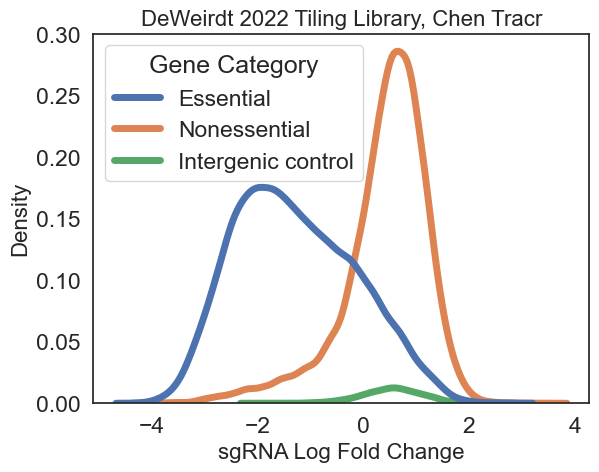

In [19]:
#note: not clean because tiling library: not filtered for on-target/off-target effects 
annotated_sgrna_lfcs_vis= annotated_sgrna_lfcs[annotated_sgrna_lfcs["Gene Category"]!='N/A'].reset_index(drop=True)
sns.set_theme(font_scale=1.5,style="white")
x = sns.kdeplot(data=annotated_sgrna_lfcs_vis, x="sgRNA_lfc", hue="Gene Category",linewidth=5)
plt.xlabel("sgRNA Log Fold Change",fontsize=16)
plt.ylabel("Density",fontsize=16)
plt.title("DeWeirdt 2022 Tiling Library, Chen Tracr",fontsize=16)


I am defining promiscuous guides as nonessential-targeting guides that are 3 standard deviations below the intergenic mean log fold change, and thus more depleted than the middle 99.7% of intergenic-targeting guides.

To minimize the chance of mislabeling guides that are depleted by chance as promiscuous, I am only defining non-promiscuous guides as those above 1 standard deviation below the intergenic mean. Thus, guides between 1 and 3 standard deviations below the intergenic mean are excluded from both the promiscuous and non-promiscuous group.


In [20]:
noness["promiscuous"]=noness["z_scored_sgRNA_lfc"]<-3

In [21]:
noness["promiscuous"].value_counts()


promiscuous
False    24609
True      1518
Name: count, dtype: int64

Acquiring the RS3 sequence scores of guides, which indicates the expected activity of the guide on the basis of its sequence features. This was acquired by running the cleaned RS3 validation set nonessentials through CRISPick with RS3Seq-Chen (no target) as the on-target scorer. 


Filtering training set to only include guides with RS3 seq score at or above 0.2. This is a broad attempt to remove inactive guides*, which are unlikely to introduce a toxic number of double stranded breaks regardless of the cumulative threat among predicted off-target sites. 

**0.2 is technically the activity cutoff for RS3 seq+target, but these metrics exist on comparable scale*

In [22]:
RS3seq_scored= pd.read_table("../Data/rs3val_nonessentialscleaned_scoredrs3seq_notarget-sgrna-designs.txt",usecols=["sgRNA Sequence","Target Gene Symbol","On-Target Ruleset","On-Target Efficacy Score"])
RS3seq_highscore= RS3seq_scored[RS3seq_scored["On-Target Efficacy Score"]>=0.2]["sgRNA Sequence"].tolist()

noness_active=noness[noness["sgRNA Sequence"].isin(RS3seq_highscore)].reset_index(drop=True).copy()
noness_active

,sgRNA Sequence,sgRNA_lfc,Target Sequence,On-target Gene Symbols,Notes,noness_targeting,z_scored_sgRNA_lfc,gene_average_zscore,promiscuous
0,AAAAAAGTATGACCACCATG,1.027727,AAAAAAGTATGACCACCATG,OR2D2,NaN,True,0.851431,0.246808,False
1,AAAAACGCAAACATCGTGCA,1.032476,AAAAACGCAAACATCGTGCA,PIWIL3,NaN,True,0.860048,0.077394,False
2,AAAAAGAACCACGAAGAGGT,-0.165353,AAAAAGAACCACGAAGAGGT,KRT28,NaN,True,-1.313654,-0.367523,False
3,AAAAAGACAAAAGAAGAGGT,1.073976,AAAAAGACAAAAGAAGAGGT,KCNK10,NaN,True,0.935358,0.371686,False
4,AAAAAGCAAGGAGAGCACAT,1.143289,AAAAAGCAAGGAGAGCACAT,NLRP4,NaN,True,1.061142,0.152342,False
...,...,...,...,...,...,...,...,...,...
9818,TTTGTAGCTGAGCACCAGCA,0.744134,TTTGTAGCTGAGCACCAGCA,"IFNA10,IFNA16,IFNA17,IFNA21,IFNA4",NaN,True,0.336793,-2.912104,False
9819,TTTGTCCAATCAGATCATAC,0.124668,TTTGTCCAATCAGATCATAC,GABRA6,NaN,True,-0.787352,0.304585,False
9820,TTTGTGAACCAACACCTGTG,0.800297,TTTGTGAACCAACACCTGTG,INS,NaN,True,0.438714,-0.638939,False
9821,TTTGTGGGGCTCAAGAAGGT,0.874180,TTTGTGGGGCTCAAGAAGGT,KRT76,NaN,True,0.572789,-0.882456,False


In [23]:
genes_targeted=RS3seq_scored[RS3seq_scored["sgRNA Sequence"].isin(noness_active["sgRNA Sequence"].tolist())]["Target Gene Symbol"].unique()
genes_targeted=[gene for gene in genes_targeted if gene in noness_gene_list]
print(len(genes_targeted),"nonessential genes targeted in final training set")
    

165 nonessential genes targeted in final training set


In [24]:
noness_active["promiscuous"].value_counts()

promiscuous
False    9117
True      706
Name: count, dtype: int64

In [25]:
noness_active=noness_active.drop(["sgRNA_lfc","Notes"],axis=1)
noness_active.to_csv("../Data/deweirdt2022tiling_nonessentials_zscored.csv",index=False)
